In [1]:
import pandas as pd
import numpy as np

1. Data Cleaning:

In [2]:
df = pd.read_excel('online_retail_II.xlsx', sheet_name='Year 2010-2011')

In [4]:
# Fill missing Customer IDs with the mean
df['Customer ID'] = df['Customer ID'].fillna(df['Customer ID'].mean())

In [5]:
# Fill missing Descriptions with the most frequent one (mode)
df['Description'] = df['Description'].fillna(df['Description'].mode()[0])

In [6]:
#Remove Duplicate Rows
df.drop_duplicates(inplace=True)

In [7]:
#Handle Canceled Orders (InvoiceNo starting with 'C')
df = df[~df['Invoice'].astype(str).str.startswith('C')]

In [9]:
#Remove or Cap Outliers
Q1_Qty = df['Quantity'].quantile(0.25)
Q3_Qty = df['Quantity'].quantile(0.75)
IQR_Qty = Q3_Qty - Q1_Qty

Q1_Price = df['Price'].quantile(0.25)
Q3_Price = df['Price'].quantile(0.75)
IQR_Price = Q3_Price - Q1_Price

# Remove rows where Quantity or Price is an outlier
df = df[
    (df['Quantity'] >= Q1_Qty - 1.5 * IQR_Qty) & (df['Quantity'] <= Q3_Qty + 1.5 * IQR_Qty) &
    (df['Price'] >= Q1_Price - 1.5 * IQR_Price) & (df['Price'] <= Q3_Price + 1.5 * IQR_Price)
]

In [10]:
#Convert InvoiceDate to Proper Datetime Format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [11]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


2. Exploratory Data Analysis (EDA):

General Overview:

In [12]:
# Total unique products
print("Unique products:", df['StockCode'].nunique())


Unique products: 3854


In [13]:
# Total number of transactions (distinct invoices)
print("Total transactions:", df['Invoice'].nunique())

Total transactions: 19294


In [14]:
# Total unique customers
print("Unique customers:", df['Customer ID'].nunique())

Unique customers: 4198


In [15]:
# Countries customers belong to
print("Total countries:", df['Country'].nunique())
print("Top countries:\n", df['Country'].value_counts().head(10))

Total countries: 38
Top countries:
 Country
United Kingdom    426179
Germany             7664
France              7185
EIRE                6270
Spain               2123
Belgium             1693
Switzerland         1631
Portugal            1325
Norway               805
Netherlands          653
Name: count, dtype: int64


Product Analysis:

In [16]:
# Create total revenue column
df['TotalPrice'] = df['Quantity'] * df['Price']

In [17]:
# Top 10 selling products by quantity
top_selling = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
print("Top 10 selling products:\n", top_selling)

Top 10 selling products:
 Description
PACK OF 72 RETROSPOT CAKE CASES       16422
ASSORTED COLOUR BIRD ORNAMENT         14363
JUMBO BAG RED RETROSPOT               14072
WHITE HANGING HEART T-LIGHT HOLDER    12468
LUNCH BAG RED RETROSPOT               10769
JAM MAKING SET PRINTED                 9682
PACK OF 60 PINK PAISLEY CAKE CASES     9040
60 TEATIME FAIRY CAKE CASES            8901
VICTORIAN GLASS HANGING T-LIGHT        8836
LUNCH BAG  BLACK SKULL.                8212
Name: Quantity, dtype: int64


In [18]:
# Top 10 products by revenue
top_revenue = df.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False).head(10)
print("Top 10 revenue-generating products:\n", top_revenue)

Top 10 revenue-generating products:
 Description
WHITE HANGING HEART T-LIGHT HOLDER    36523.42
PARTY BUNTING                         36503.77
JUMBO BAG RED RETROSPOT               32332.62
JAM MAKING SET WITH JARS              24945.23
ASSORTED COLOUR BIRD ORNAMENT         24838.11
SPOTTY BUNTING                        23725.90
PAPER CHAIN KIT 50'S CHRISTMAS        22553.28
NATURAL SLATE HEART CHALKBOARD        21375.21
HOT WATER BOTTLE KEEP CALM            21266.71
DOORMAT KEEP CALM AND COME IN         20941.66
Name: TotalPrice, dtype: float64


In [19]:
# Products with zero or negative prices
bad_price_products = df[df['Price'] <= 0]
print("Products with zero or negative unit prices:", bad_price_products['Description'].nunique())

Products with zero or negative unit prices: 226


Customer Analysis:

In [20]:
# Customers who bought the most products (by quantity)
top_customers = df.groupby('Customer ID')['Quantity'].sum().sort_values(ascending=False).head(10)
print("Top customers by quantity:\n", top_customers)

Top customers by quantity:
 Customer ID
15287.68416    301904
14911.00000     50175
13089.00000     20566
17841.00000     19720
14298.00000     17584
12748.00000     15098
14096.00000     13815
13081.00000     12063
15159.00000      8286
15311.00000      8224
Name: Quantity, dtype: int64


In [21]:
# Distribution of number of purchases per customer (number of invoices)
import matplotlib.pyplot as plt

In [23]:
purchase_dist = df.groupby('Customer ID')['Invoice'].nunique()

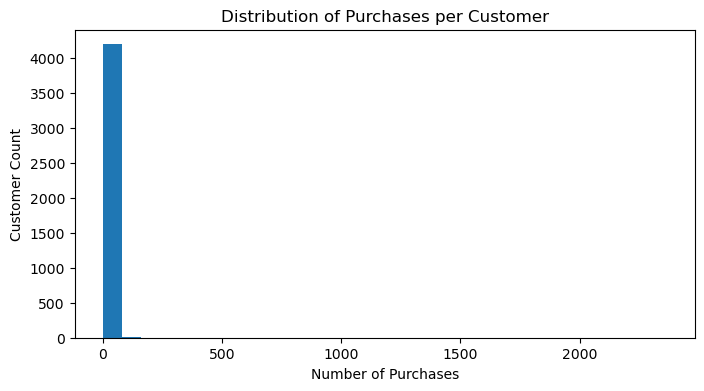

Most loyal customers:
 Customer ID
15287.68416    2365
12748.00000     199
14911.00000     194
17841.00000     123
15311.00000      91
14606.00000      90
13089.00000      82
12971.00000      79
14527.00000      54
13408.00000      52
Name: Invoice, dtype: int64


In [24]:
plt.figure(figsize=(8, 4))
purchase_dist.plot(kind='hist', bins=30)
plt.title('Distribution of Purchases per Customer')
plt.xlabel('Number of Purchases')
plt.ylabel('Customer Count')
plt.show()

# Loyal customers: high number of invoices
loyal_customers = purchase_dist.sort_values(ascending=False).head(10)
print("Most loyal customers:\n", loyal_customers)

Time Series & Seasonal Trends:

In [25]:
# Convert InvoiceDate to datetime again if needed
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

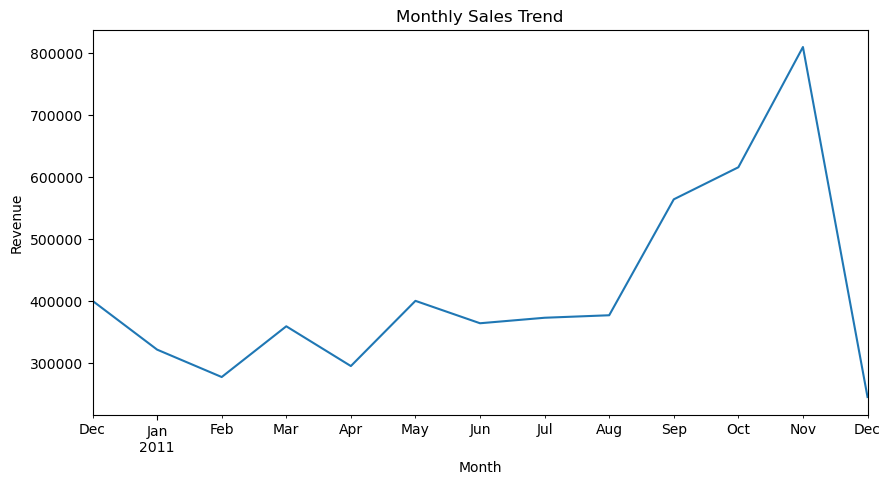

In [26]:
# Monthly sales trend
df['Month'] = df['InvoiceDate'].dt.to_period('M')
monthly_sales = df.groupby('Month')['TotalPrice'].sum()

monthly_sales.plot(kind='line', title='Monthly Sales Trend', figsize=(10, 5))
plt.ylabel('Revenue')
plt.show()

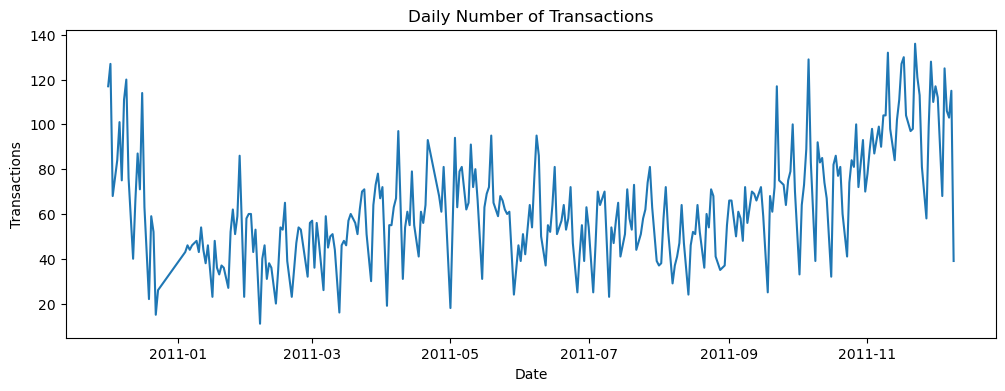

In [27]:
# Daily transaction pattern
df['Date'] = df['InvoiceDate'].dt.date
daily_orders = df.groupby('Date')['Invoice'].nunique()

daily_orders.plot(kind='line', title='Daily Number of Transactions', figsize=(12, 4))
plt.ylabel('Transactions')
plt.show()


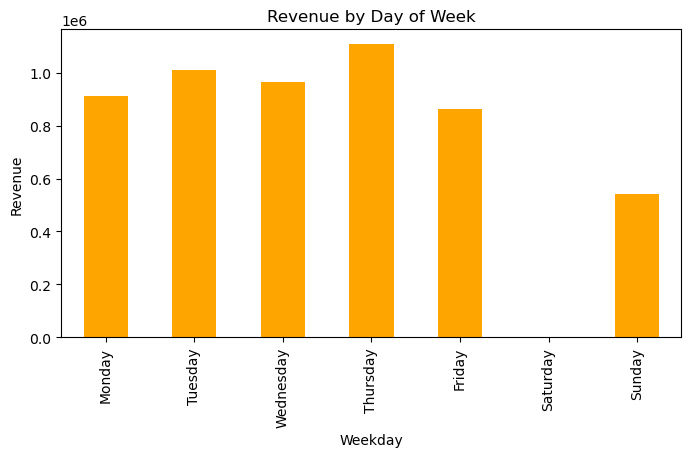

In [28]:
# Weekly pattern
df['Weekday'] = df['InvoiceDate'].dt.day_name()
weekday_sales = df.groupby('Weekday')['TotalPrice'].sum()

# Order days (to keep Mon-Sun order)
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_sales = weekday_sales.reindex(order)

weekday_sales.plot(kind='bar', title='Revenue by Day of Week', figsize=(8, 4), color='orange')
plt.ylabel('Revenue')
plt.show()

Country Analysis:

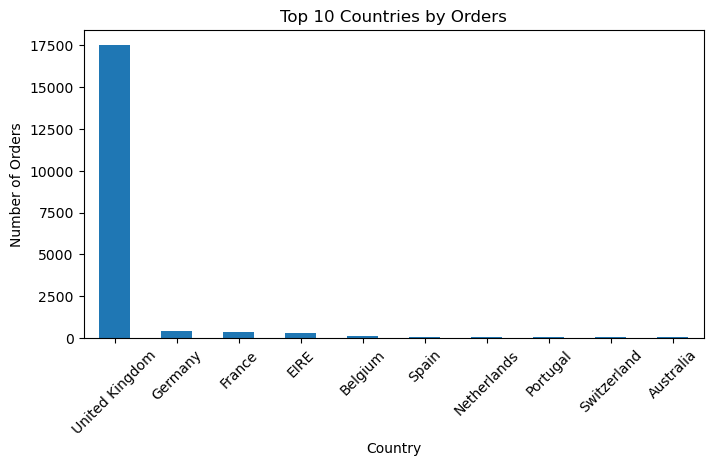

In [29]:
# Countries with highest number of orders
orders_by_country = df.groupby('Country')['Invoice'].nunique().sort_values(ascending=False).head(10)
orders_by_country.plot(kind='bar', title='Top 10 Countries by Orders', figsize=(8, 4))
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.show()

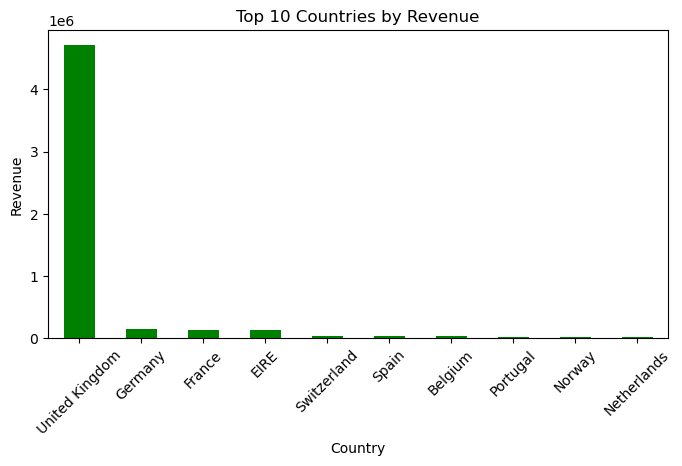

In [30]:
# Revenue comparison across countries
revenue_by_country = df.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).head(10)
revenue_by_country.plot(kind='bar', title='Top 10 Countries by Revenue', figsize=(8, 4), color='green')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.show()

RFM (Recency, Frequency, Monetary) Segmentation:

In [32]:
# Define reference date (usually day after last transaction)
NOW = df['InvoiceDate'].max() + pd.Timedelta(days=1)

In [33]:
# RFM values per customer
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (NOW - x.max()).days,
    'Invoice': 'nunique',
    'TotalPrice': 'sum'
})

In [34]:
rfm.columns = ['Recency', 'Frequency', 'Monetary']


In [35]:
# Optional: Display top customers
print("Top RFM customers:\n", rfm.sort_values(by='Monetary', ascending=False).head(5))


Top RFM customers:
              Recency  Frequency   Monetary
Customer ID                               
15287.68416        1       2365  859624.93
14911.00000        1        194   91209.24
13089.00000        4         82   38565.78
14096.00000        4         17   38556.58
17841.00000        2        123   33847.34


In [36]:
# Assign RFM scores (1 = best, 5 = worst)
rfm['R'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])
rfm['F'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['M'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])

rfm['RFM_Score'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)

In [37]:
# Display top RFM segments
print("Best (111) Customers:\n", rfm[rfm['RFM_Score'] == '111'].head())

Best (111) Customers:
              Recency  Frequency  Monetary  R  F  M RFM_Score
Customer ID                                                 
12353.0          204          1     29.30  1  1  1       111
12361.0          287          1    174.90  1  1  1       111
12401.0          303          1     32.85  1  1  1       111
12435.0          268          1     78.00  1  1  1       111
12441.0          367          1    155.55  1  1  1       111


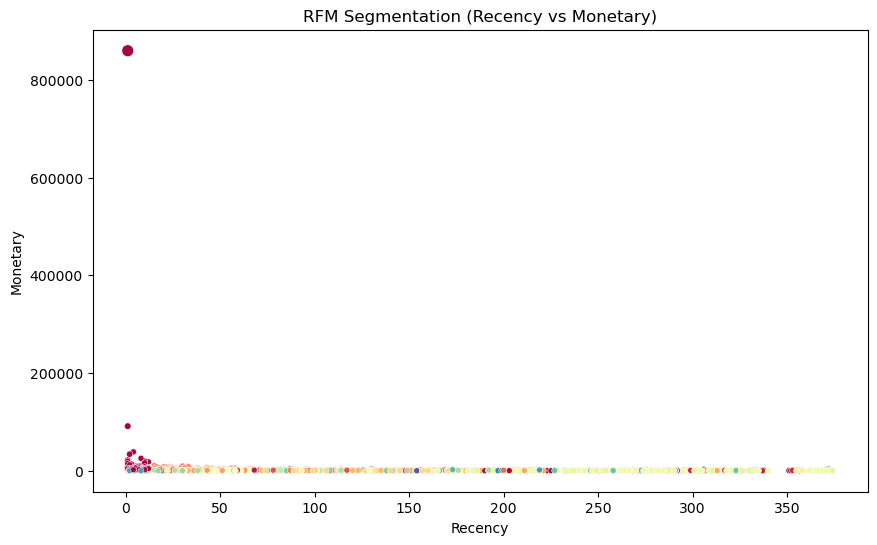

In [38]:
# Plot Recency vs Monetary with Frequency size
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', size='Frequency', hue='RFM_Score', palette='Spectral', legend=False)
plt.title('RFM Segmentation (Recency vs Monetary)')
plt.show()

In [40]:
df.to_csv('cleaned_retail_data.csv', index=False, encoding='utf-8')


In [41]:
from IPython.display import FileLink
FileLink('cleaned_retail_data.csv')


C:\Users\Dell Latitude\cleaned_retail_data.csv